## Imports and auxillaries

In [1]:
%load_ext autoreload
%autoreload 1

%run auxillary_functions.ipynb

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

## Model initialisation and adding states

In [3]:
# Initialize the model
model = HiddenMarkovModel(name = "Example Model")

# emission probability distributions, P(umbrella | weather)
sunny_emissions = DiscreteDistribution({'yes': 0.1, 'no': 0.9})
sunny_state = State(sunny_emissions, name = 'Sunny')

rainy_emissions = DiscreteDistribution({'yes': 0.8, 'no': 0.2})
rainy_state = State(rainy_emissions, name = 'Rainy')

# add states to the model
model.add_states(sunny_state, rainy_state)

assert rainy_emissions.probability('yes') == 0.8, 'The director brings his umbrella with probability 0.8 on rainy days'

## Add initial probabilities and transitions

In [4]:
# add initial (equal) probabilites of a sequence Monday - Friday
model.add_transition(model.start, sunny_state, 0.5)
model.add_transition(model.start, rainy_state, 0.5)

# add sunny day transitions
model.add_transition(sunny_state, sunny_state, 0.8)
model.add_transition(sunny_state, rainy_state, 0.2)

# add rainy day transitions
model.add_transition(rainy_state, sunny_state, 0.4)
model.add_transition(rainy_state, rainy_state, 0.6)

# finalise the model with the bake method
model.bake()

assert model.edge_count() == 6, 'There should be two edges from model.start, two from Rainy, and two from Sunny'
assert model.node_count() == 4, 'The states should include model.start, model.end, Rainy, and Sunny'

## Model visualisation

C:\Users\User\AppData\Local\Temp\ipykernel_19688\94040051.py:16: DeprecationWarning: nx.nx_pydot.to_pydot depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  pydot_graph = nx.drawing.nx_pydot.to_pydot(g)


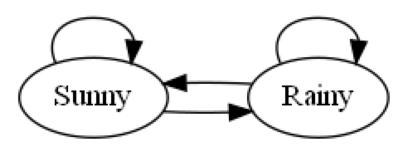

In [6]:
show_model(model, figsize=(5, 5), filename="example.png", overwrite=True, show_ends=False)

In [11]:
model.dense_transition_matrix()

array([[0.6, 0.4, 0. , 0. ],
       [0.2, 0.8, 0. , 0. ],
       [0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. ]])

In [60]:
column_order = ["Example Model-start", "Sunny", "Rainy", "Example Model-end"]  # Override the Pomegranate default order
column_names = [s.name for s in model.states]
order_index = [column_names.index(c) for c in column_order]

# re-order the rows/columns to match the specified column order
transitions = model.dense_transition_matrix()[:, order_index][order_index, :]
print("The state transition matrix, P(Xt|Xt-1):\n")
print(transitions)
print("\nThe transition probability from Rainy to Sunny is {:.0f}%".format(100 * transitions[2, 1]))

The state transition matrix, P(Xt|Xt-1):

[[0.  0.5 0.5 0. ]
 [0.  0.8 0.2 0. ]
 [0.  0.4 0.6 0. ]
 [0.  0.  0.  0. ]]

The transition probability from Rainy to Sunny is 40%


In [61]:
pd.DataFrame(model.dense_transition_matrix(), columns = [s.name for s in model.states], index = [s.name for s in model.states])

,Rainy,Sunny,Example Model-start,Example Model-end
Rainy,0.6,0.4,0.0,0.0
Sunny,0.2,0.8,0.0,0.0
Example Model-start,0.5,0.5,0.0,0.0
Example Model-end,0.0,0.0,0.0,0.0


## Sequence Likelihood Calculation

In [42]:
observations = ['yes', 'no', 'yes']
assert len(observations) > 0, 'Choose a sequence of yes/no observations to test'

forward_matrix = np.exp(model.forward(observations))
probability_percentage = np.exp(model.log_probability(observations))

print("         " + "".join(s.name.center(len(s.name)+6) for s in model.states))
for i in range(len(observations) + 1):
    print(" <start> " if i==0 else observations[i - 1].center(9), end="")
    print("".join("{:.0f}%".format(100 * forward_matrix[i, j]).center(len(s.name) + 6)
                  for j, s in enumerate(model.states)))

print("\nThe likelihood over all possible paths " + \
      "of this model producing the sequence {} is {:.2f}%\n\n"
      .format(observations, 100 * probability_percentage))

            Rainy      Sunny      Example Model-start      Example Model-end   
 <start>      0%         0%               100%                     0%          
   yes       40%         5%                0%                      0%          
    no        5%        18%                0%                      0%          
   yes        5%         2%                0%                      0%          

The likelihood over all possible paths of this model producing the sequence ['yes', 'no', 'yes'] is 6.92%




In [47]:
# Maximum likelihood sequence
viterbi_likelihood, viterbi_path = model.viterbi(observations)

print("The most likely weather sequence to have generated " + \
      "these observations is {} at {:.2f}%."
      .format([s[1].name for s in viterbi_path[1:]], np.exp(viterbi_likelihood)*100)
)

The most likely weather sequence to have generated these observations is ['Rainy', 'Sunny', 'Rainy'] at 2.30%.


In [48]:
from itertools import product

observations = ['no', 'no', 'yes']

p = {'Sunny': {'Sunny': np.log(.8), 'Rainy': np.log(.2)}, 'Rainy': {'Sunny': np.log(.4), 'Rainy': np.log(.6)}}
e = {'Sunny': {'yes': np.log(.1), 'no': np.log(.9)}, 'Rainy':{'yes':np.log(.8), 'no':np.log(.2)}}
o = observations
k = []
vprob = np.exp(model.viterbi(o)[0])
print("The likelihood of observing {} if the weather sequence is...".format(o))
for s in product(*[['Sunny', 'Rainy']]*3):
    k.append(np.exp(np.log(.5)+e[s[0]][o[0]] + p[s[0]][s[1]] + e[s[1]][o[1]] + p[s[1]][s[2]] + e[s[2]][o[2]]))
    print("\t{} is {:.2f}% {}".format(s, 100 * k[-1], " <-- Viterbi path" if k[-1] == vprob else ""))
print("\nThe total likelihood of observing {} over all possible paths is {:.2f}%".format(o, 100*sum(k)))

The likelihood of observing ['no', 'no', 'yes'] if the weather sequence is...
	('Sunny', 'Sunny', 'Sunny') is 2.59% 
	('Sunny', 'Sunny', 'Rainy') is 5.18%  <-- Viterbi path
	('Sunny', 'Rainy', 'Sunny') is 0.07% 
	('Sunny', 'Rainy', 'Rainy') is 0.86% 
	('Rainy', 'Sunny', 'Sunny') is 0.29% 
	('Rainy', 'Sunny', 'Rainy') is 0.58% 
	('Rainy', 'Rainy', 'Sunny') is 0.05% 
	('Rainy', 'Rainy', 'Rainy') is 0.58% 

The total likelihood of observing ['no', 'no', 'yes'] over all possible paths is 10.20%
